# Toy example of AR-DAE
Partial implementation of the paper "AR-DAE: Towards Unbiased Neural Entropy Gradient Estimation"

## 1. imports and helper functions

In [0]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

class SwissRoll:                                                                                                      
    """
    Swiss roll distribution sampler.
    noise control the amount of noise injected to make a thicker swiss roll
    """
    def spl(self, n, noise=0.5):
        return torch.from_numpy(
            make_swiss_roll(n, noise)[0][:, [0, 2]].astype('float32') / 3.)

sampler = SwissRoll()

## 2. Define AR-DAEs

In [0]:
class resARDAE(nn.Module):
    def __init__(self,
                 input_dim=2,
                 hidden_dim=64,
                 ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(                                                                                            
            nn.Linear(input_dim+1, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, input_dim)
            )

    def add_noise(self, input, std):
        eps = torch.randn_like(input)
        return input + std*eps, eps

    def loss(self, input, target):
        recon_loss = F.mse_loss(input, target)
        return recon_loss

    def forward(self, input, std):
        input = input.view(-1, self.input_dim)
        assert torch.is_tensor(std)
        x_bar, eps = self.add_noise(input, std) # add noise
        h = torch.cat([x_bar, std], dim=1) # concat
        glogprob = self.main(h) # predict
        loss = self.loss(std*glogprob, -eps) # loss
        # return
        return glogprob, loss

    def glogprob(self, input, std):
        input = input.view(-1, self.input_dim)
        assert torch.is_tensor(std)
        h = torch.cat([input, std], dim=1) # concat
        glogprob = self.main(h) # predict
        return glogprob

def _grad(logprob, input):
    return torch.autograd.grad(logprob, input, retain_graph=True, create_graph=True)[0]

class gradARDAE(nn.Module):
    def __init__(self,
                 input_dim=2,
                 hidden_dim=64,
                 ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(                                                                                            
            nn.Linear(input_dim+1, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, 1)
            )

    def add_noise(self, input, std):
        eps = torch.randn_like(input)
        return input + std*eps, eps

    def loss(self, input, target):
        recon_loss = F.mse_loss(input, target)
        return recon_loss

    def forward(self, input, std):
        input = input.view(-1, self.input_dim)
        assert torch.is_tensor(std)
        x_bar, eps = self.add_noise(input, std) # add noise
        x_bar.requires_grad = True # grad true
        h = torch.cat([x_bar, std], dim=1) # concat
        logprob = -self.main(h) # (unnorm) logprob
        glogprob = _grad(logprob.sum(), x_bar) # predict
        loss = self.loss(std*glogprob, -eps) # loss
        # return
        return glogprob, loss

    def glogprob(self, input, std):
        input = input.view(-1, self.input_dim)
        assert torch.is_tensor(std)
        input.requires_grad = True # grad true
        h = torch.cat([input, std], dim=1) # concat
        logprob = -self.main(h) # (unnorm) logprob
        glogprob = _grad(logprob.sum(), input) # predict
        return glogprob

## 3. init and training


In [0]:
# init
device = torch.device('cuda') # device
delta = 1.0 # prior variance
num_sigma = 10 # number of noise scale samples
input_dim = 2 # dim of input
hidden_dim = 128 # dim of hidden units in DAE
lr = 0.005 # learning rate
iterations = 5000 # number of iterations
batch_size = 256 # mini-batch size
log_interval = 500 # log interval

# model
#dae = resARDAE(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
dae = gradARDAE(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(dae.parameters(), lr=lr)

# train
start_time = time.time()
for i_ep in range(iterations):
    optimizer.zero_grad()
    x = sampler.spl(batch_size).to(device) # sample data
    sigma = delta*torch.randn(batch_size*num_sigma, 1, device=device) # 1 x 1
    x = x.unsqueeze(1).expand(batch_size, num_sigma, input_dim).contiguous().view(batch_size*num_sigma, input_dim) # broadcast data
    grad, loss = dae(x, sigma) # forward
    loss.backward() # backward
    optimizer.step()
    if (i_ep+1) % log_interval == 0:
        elapsed = time.time() - start_time
        print('| {:5d}/{:5d} | ms/step {:5.2f} | delta {:5.3f} | loss (dae) {:5.3f} '.format(
              i_ep+1, iterations, elapsed*1000/log_interval, delta, loss.item()))
        start_time = time.time()

|   500/ 5000 | ms/step  5.77 | delta 1.000 | loss (dae) 0.761 
|  1000/ 5000 | ms/step  5.38 | delta 1.000 | loss (dae) 0.677 
|  1500/ 5000 | ms/step  4.76 | delta 1.000 | loss (dae) 0.669 
|  2000/ 5000 | ms/step  4.71 | delta 1.000 | loss (dae) 0.667 
|  2500/ 5000 | ms/step  4.99 | delta 1.000 | loss (dae) 0.715 
|  3000/ 5000 | ms/step  4.69 | delta 1.000 | loss (dae) 0.698 
|  3500/ 5000 | ms/step  4.62 | delta 1.000 | loss (dae) 0.683 
|  4000/ 5000 | ms/step  4.96 | delta 1.000 | loss (dae) 0.689 
|  4500/ 5000 | ms/step  5.16 | delta 1.000 | loss (dae) 0.687 
|  5000/ 5000 | ms/step  4.59 | delta 1.000 | loss (dae) 0.716 


## 4. visualize

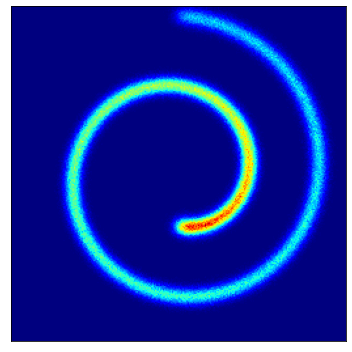

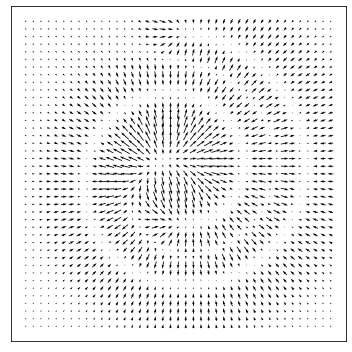

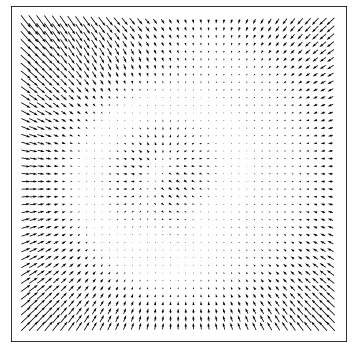

In [0]:
''' visualize '''
def get_2d_histogram_plot(data):
    # get histogram
    heatmap, xedges, yedges = np.histogram2d(
        data[:, 0],
        data[:, 1],
        range=[[-5, 5], [-5, 5]],
        bins=256,
        )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # plot heatmap
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(heatmap.T, extent=extent, cmap='jet', origin='lower')
    ax.grid(False)
    plt.xticks([])
    plt.yticks([])

    # tight
    plt.tight_layout()

# plot data
get_2d_histogram_plot(sampler.spl(1000000).numpy())

# coordinates for plotting gradient vector field
nbins = 41
x1 = torch.linspace(-5, 5, nbins).float()
x2 = torch.linspace(-5, 5, nbins).float()
X2, X1 = torch.meshgrid(x1, x2)
data = torch.cat([X1.flatten().unsqueeze(1),X2.flatten().unsqueeze(1)], 1).to(device)

# plot learned grad
for delta in [0, 1.0]:
    sigma = torch.zeros(data.shape[0],1).fill_(delta).to(device)
    grad = dae.glogprob(data, sigma)
    grad = grad.cpu().data
    plt.figure(figsize=(5, 5))
    g1, g2 = grad[:,0].numpy(), grad[:,1].numpy()
    plt.quiver(x1,x2,g1.reshape(nbins,nbins),g2.reshape(nbins,nbins), pivot='mid')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()